In [1]:
import numpy as np
import pandas as pd                                                                   
import pickle
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# Data Read and Clean

In [3]:
df = pd.read_csv('./insurance.csv',na_values='NA')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


By looking at the statistics, we think that the bmi might have some outliers since the maximum value is so large.

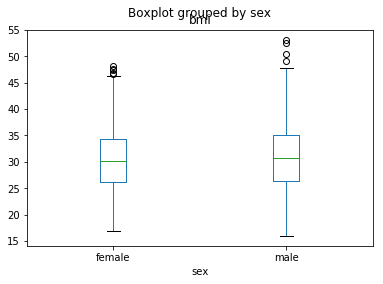

In [6]:
lines = df.boxplot(column='bmi', by='sex', return_type='dict' ,grid=False)
# ax.set_title('');

In [7]:
lines['bmi']['fliers'][0].get_ydata()

array([48.07, 46.75, 47.41, 46.7 , 47.6 ])

In [8]:
df[df.sex=='female'].sort_values(by='bmi', ascending=False).head(5)

,age,sex,bmi,children,smoker,region,charges
286,46,female,48.07,2,no,northeast,9432.92530
860,37,female,47.60,2,yes,southwest,46113.51100
543,54,female,47.41,0,yes,southeast,63770.42801
438,52,female,46.75,5,no,southeast,12592.53450
547,54,female,46.70,2,no,southwest,11538.42100


In [9]:
df = df.drop([286,860,543,438,547])

In [10]:
lines['bmi']['fliers'][1].get_ydata()

array([49.06, 50.38, 52.58, 53.13])

In [11]:
df[df.sex=='male'].sort_values(by='bmi',ascending=False).head(4)

,age,sex,bmi,children,smoker,region,charges
1317,18,male,53.13,0,no,southeast,1163.4627
1047,22,male,52.58,1,yes,southeast,44501.3982
847,23,male,50.38,1,no,southeast,2438.0552
116,58,male,49.06,0,no,southeast,11381.3254


In [12]:
df = df.drop([1317,1047,47,116])

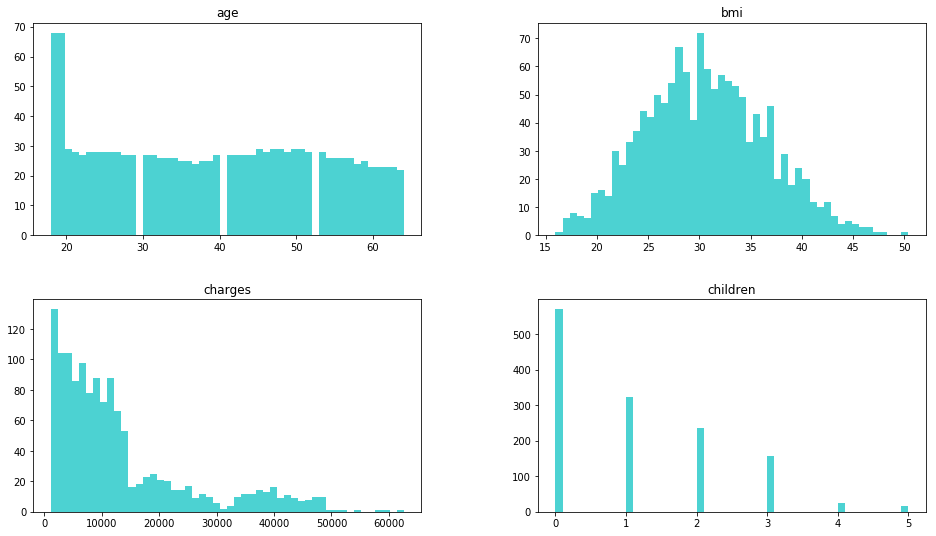

In [13]:
df.hist(bins=50,figsize=(16,9),color='c',alpha=0.7,grid=False);

# Relationship Between BMI and Insurance Fee

## Correlation

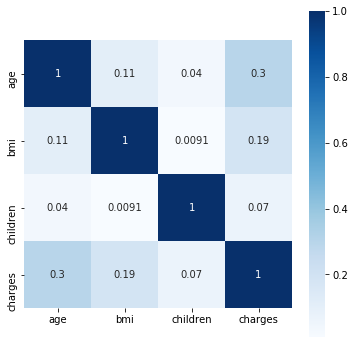

In [14]:
def corr_heat(df):
    dfData = abs(df.corr())
    plt.subplots(figsize=(6, 6))
    sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap='Blues')
    plt.show()
corr_heat(df)

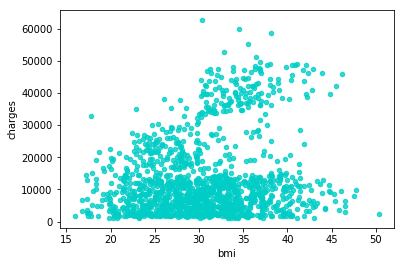

In [15]:
df.plot('bmi', 'charges', kind='scatter',color='#00cdc6', alpha=0.8, grid=False)

## Anova Test

In [16]:
df.loc[:, 'bmi_cat'] = pd.cut(df.bmi, bins=[0, 18.5, 32, 60], 
                                labels=['thin', 'ideal', 'fat'] )
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_cat
0,19,female,27.900,0,yes,southwest,16884.92400,ideal
1,18,male,33.770,1,no,southeast,1725.55230,fat
2,28,male,33.000,3,no,southeast,4449.46200,fat
3,33,male,22.705,0,no,northwest,21984.47061,ideal
4,32,male,28.880,0,no,northwest,3866.85520,ideal


In [17]:
thin = df[df.bmi_cat=='thin'].charges.to_numpy()
ideal = df[df.bmi_cat=='ideal'].charges.to_numpy()
fat = df[df.bmi_cat=='fat'].charges.to_numpy()

In [18]:
f_obs = stats.f_oneway(thin,ideal,fat)
f_obs

F_onewayResult(statistic=21.008551065857286, pvalue=1.0415359150584232e-09)

The p-value is extremely small, but we need to check the assumptions. The key assumption is that the residuals are normally distributed. This function does not return us the residuals, so we compute them ourselves.

In [19]:
mean = df['bmi'].mean()
df.loc[:,'res1'] = df['bmi'].apply(lambda x: x - mean)

In [20]:
df.groupby('bmi_cat').res1.describe()

,count,mean,std,min,25%,50%,75%,max
bmi_cat,,,,,,,,
thin,21.0,-12.939741,0.626958,-14.590455,-13.260455,-12.880455,-12.500455,-12.050455
ideal,778.0,-3.659343,3.294445,-11.950455,-6.130455,-3.122955,-0.815455,1.449545
fat,530.0,5.884347,3.437244,1.459545,3.087045,5.264545,7.805795,19.829545


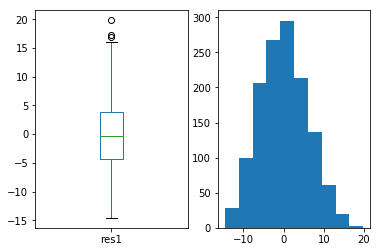

In [21]:
#plt.figure(1, figsize=(10, 5))
plt.subplot(121)
df.res1.plot(kind='box')

plt.subplot(122)
df.res1.hist(grid=False)


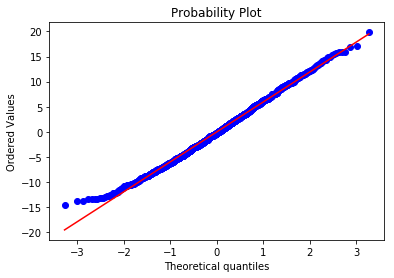

In [22]:
_ = stats.probplot(df.res1, plot=plt)

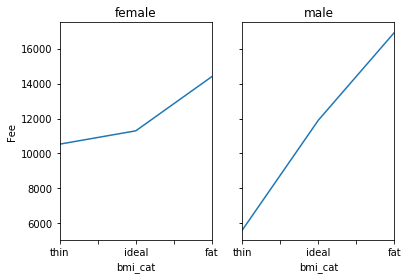

In [23]:
ax1 = plt.subplot(121)
df[df.sex=='female'].groupby('bmi_cat')['charges'].mean().plot()
plt.title('female');
plt.ylabel('Fee');
plt.subplot(122, sharey=ax1)
df[df.sex=='male'].groupby('bmi_cat')['charges'].mean().plot()
plt.title('male');
plt.ylabel('Fee');

# Relationship Between Smoking and Insurance Fee

## Visualize the Smoker and Fees

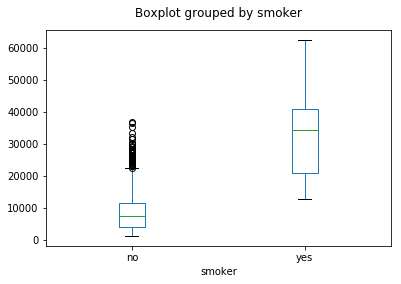

In [24]:
ax= df.boxplot(column='charges',by='smoker',grid=False)
ax.set_title('');

### Peform T test

Hypothesis:
* NO= There is no difference on chareges bwtween the smoker and non-smoker
* N1= There are significant different between the two groups

In [25]:
t1= stats.ttest_ind(df.charges[df.smoker=='no'],df.charges[df.smoker=='yes'],equal_var =False)
print(' The test statistic value is {:.3f}.'.format(t1[0]))
print(' The corresponding p-value is {:.3f}.'.format(t1[1]))

 The test statistic value is -32.693.
 The corresponding p-value is 0.000.


## Check the assumption

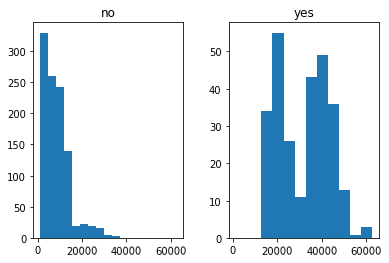

In [26]:
df.hist('charges','smoker',sharex=True, xrot=True);

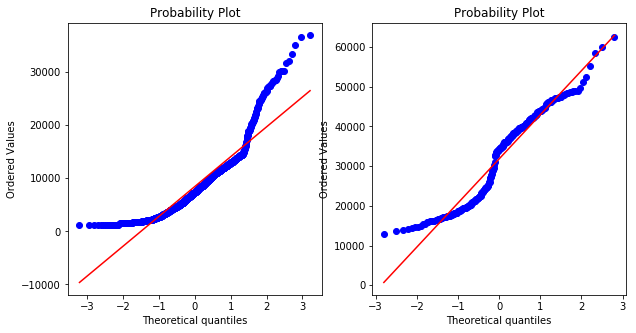

In [27]:
plt.figure(1, figsize=(10, 5))
plt.subplot(121)
_= stats.probplot(df.charges[df.smoker == 'no'], dist="norm", plot=plt)
plt.subplot(122)
_ = stats.probplot(df.charges[df.smoker == 'yes'], dist="norm", plot=plt)

It seems somehow fitted, but the tails of the first plot is far and the middle of the secondplot seems not fitted well.

In [28]:
df.groupby('smoker').charges.describe()

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1058.0,8435.156784,6001.849181,1121.8739,3988.404750,7341.4160,11355.802575,36910.60803
yes,271.0,31835.343855,11384.541798,12829.4551,20759.808425,34303.1672,40936.857450,62592.87309


Since the STD have twice more difference, and the values are not normal distributed, we can try bootstrap method.

## Peform Bootstrap Method


In [29]:
m0= df.charges.mean()
df['res'] = df.charges - m0
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_cat,res1,res
0,19,female,27.900,0,yes,southwest,16884.92400,ideal,-2.650455,3678.171508
1,18,male,33.770,1,no,southeast,1725.55230,fat,3.219545,-11481.200192
2,28,male,33.000,3,no,southeast,4449.46200,fat,2.449545,-8757.290492
3,33,male,22.705,0,no,northwest,21984.47061,ideal,-7.845455,8777.718118
4,32,male,28.880,0,no,northwest,3866.85520,ideal,-1.670455,-9339.897292


In [30]:
def one_iter():
    xx = np.random.choice(df.res, size=1064, replace=True) + m0
    xx2=np.random.choice(df.res, size=274, replace=True) + m0
    f_bs = stats.f_oneway(xx,xx2)
    return f_bs[0]

np.random.seed(400)
bs_out = pd.Series([one_iter() for x in np.arange(0, 1000)])

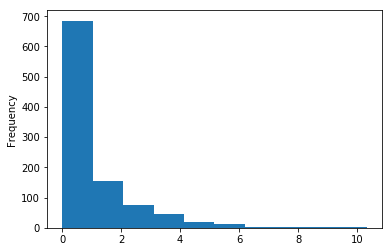

In [31]:
bs_out.plot(kind='hist');

Since the previous calculated statistical value is |-32| which is much larger than the results, the difference is significant.

# Relationship Between Gender and Insurance Fee/ Smoker

Firstly, we would like to verigy that if gender strongly infuluence smoking.

In [32]:
ct = pd.crosstab(df.sex, df.smoker, normalize=True)

In [33]:
chi2,p, _, exp = stats.chi2_contingency(ct, correction=True)
p

0.01618989288317187

Thus, we conclude that gender and smoking is dependent.

Then we'd like to see the relationship among gender, smoker, and insurance fee.


## Gender & Insurance Fee
### Visualization

In [34]:
df.groupby(['sex']).count()

,age,bmi,children,smoker,region,charges,bmi_cat,res1,res
sex,,,,,,,,,
female,656,656,656,656,656,656,656,656,656
male,673,673,673,673,673,673,673,673,673


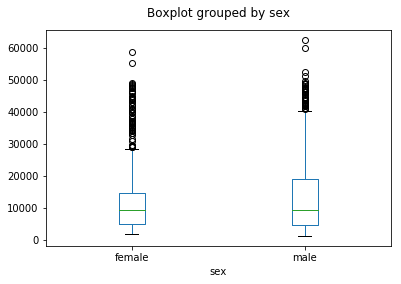

In [35]:
ax= df.boxplot(column='charges',by='sex',grid=False)
ax.set_title('');

In [36]:
t1= stats.ttest_ind(df.charges[df.sex=='male'],df.charges[df.sex=='female'],equal_var =True)
print(' The test statistic value is {:.3f}.'.format(t1[0]))
print(' The corresponding p-value is {:.3f}.'.format(t1[1]))

 The test statistic value is 2.242.
 The corresponding p-value is 0.025.


### Check the Assumption

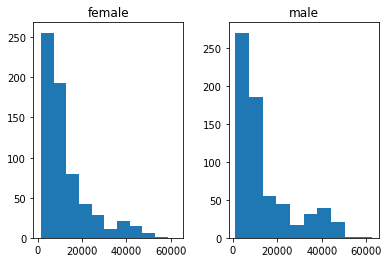

In [37]:
df.hist('charges','sex',sharex=True, xrot=True);

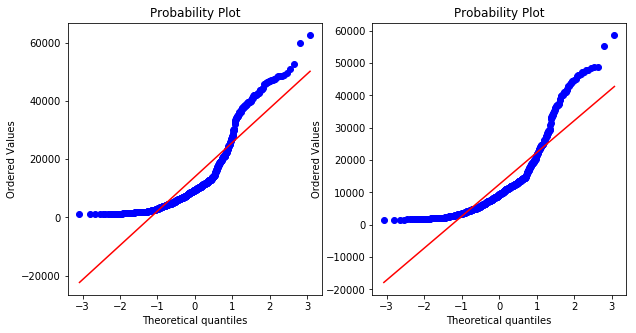

In [38]:
plt.figure(1, figsize=(10, 5))
plt.subplot(121)
_= stats.probplot(df.charges[df.sex == 'male'], dist="norm", plot=plt)
plt.subplot(122)
_ = stats.probplot(df.charges[df.sex == 'female'], dist="norm", plot=plt)

In [39]:
df.groupby('sex').charges.describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,656.0,12460.451909,10913.741957,1607.5101,4870.557,9274.1795,14452.787375,58571.07448
male,673.0,13934.201501,12936.627400,1121.8739,4646.759,9361.3268,18972.495000,62592.87309


Since the QQ plot didn't seens to be well fitted, we can try Bootstrap Method instead.
### Bootstrap Method
Hypothesis:
* NO = There is no difference on charges between two genders
* N1 = There are significant different between two genders

In [40]:
m0= df.charges.mean()
df['res'] = df.charges - m0
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_cat,res1,res
0,19,female,27.900,0,yes,southwest,16884.92400,ideal,-2.650455,3678.171508
1,18,male,33.770,1,no,southeast,1725.55230,fat,3.219545,-11481.200192
2,28,male,33.000,3,no,southeast,4449.46200,fat,2.449545,-8757.290492
3,33,male,22.705,0,no,northwest,21984.47061,ideal,-7.845455,8777.718118
4,32,male,28.880,0,no,northwest,3866.85520,ideal,-1.670455,-9339.897292


In [41]:
def one_iter():
    xx = np.random.choice(df.res, size=1352, replace=True) + m0
    f_bs = stats.f_oneway(*xx.reshape(2,676))
    return f_bs[0]


np.random.seed(400)
bs_out = pd.Series([one_iter() for x in np.arange(0, 1000)])

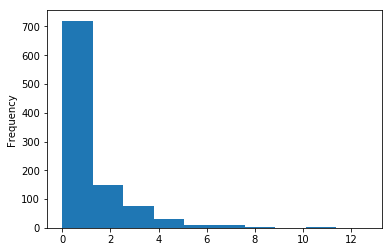

In [42]:
bs_out.plot(kind='hist');

Since the previous statistic value is about 2.1, there are still some values larger than it. Therefore, it's not sufficient for us to reject the null hypothesis.

There is no significant difference between genders.

## Gender, Smoker vs. Insurance Fee


In [43]:
insurance_table = df.pivot_table(index='sex', columns='smoker', values='charges',
               aggfunc=lambda x: np.mean(x))

In [44]:
insurance_table

smoker,no,yes
sex,,
female,8758.482173,30249.563122
male,8094.252540,32969.478176


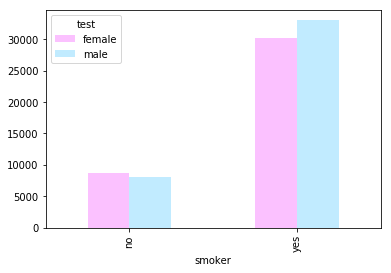

In [45]:
insurance_table.T.plot.bar(color=['#fab2ff','#b2e7ff'],alpha=0.8)
plt.legend(title='test');

# Relationship Between Age and Smoker

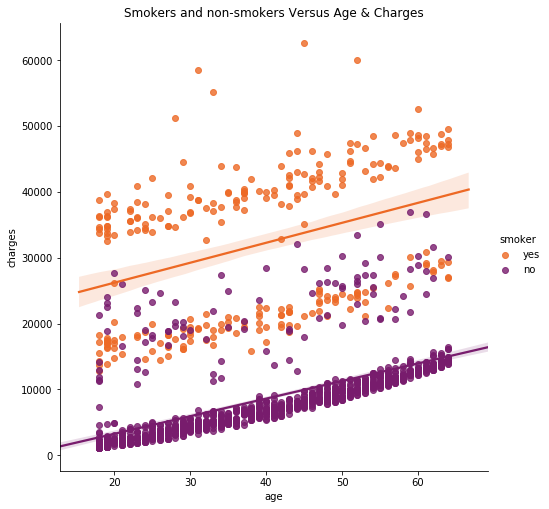

In [46]:
sns.lmplot(x='age', y='charges', hue='smoker', data=df, palette = 'inferno_r', height = 7)
plt.title('Smokers and non-smokers Versus Age & Charges');

It is obvious that smokers will spend much more on insurance than non-smokers.

# Relationship Between Age and Insurance Fee

In [47]:
df.loc[:, 'age_cat'] = pd.cut(df.age, bins=[17, 44, 59, 90], 
                                labels=['young','mid-age','old'] )

In [48]:
pd.DataFrame(df.age.describe()).T

,count,mean,std,min,25%,50%,75%,max
age,1329.0,39.194883,14.047267,18.0,27.0,39.0,51.0,64.0


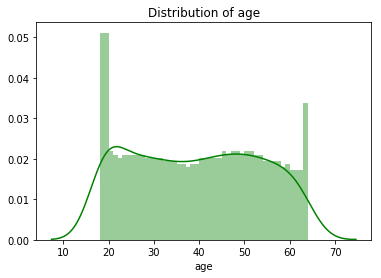

In [49]:
# df['age'].hist(grid=False, bins=np.arange(16,65), figsize=(5,4));
plt.title("Distribution of age")
ax = sns.distplot(df['age'], color = 'green', bins=np.arange(16,65))

From the plot, we can see that youngest and oldest generation have the most data samples.

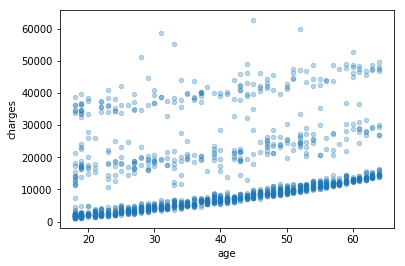

In [50]:
df.plot('age', 'charges', kind='scatter', alpha=0.3);

We can see that there's a strong correlation between charges and age.

In [51]:
df[['charges','age']].corr().round(3)

,charges,age
charges,1.000,0.302
age,0.302,1.000


However, the calculated correlation does not give the same answer.

In [52]:
pd.DataFrame(df.charges.describe()).T

,count,mean,std,min,25%,50%,75%,max
charges,1329.0,13206.752492,11999.054183,1121.8739,4738.2682,9304.7019,16586.49771,62592.87309


In [53]:
df.charges.sort_values(ascending=False).head(10)

1300    62592.87309
1230    60021.39897
577     58571.07448
819     55135.40209
1146    52590.82939
34      51194.55914
1241    49577.66240
1062    48970.24760
488     48885.13561
175     48824.45000
Name: charges, dtype: float64

In [54]:
df.loc[:, 'charges_cat'] = pd.cut(df.charges, bins=[0, 13000, 32000, 65000], 
                                labels=['low','mid','high'] )

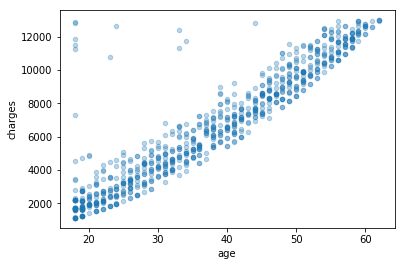

In [55]:
df_low = df[df.charges_cat == 'low']
df_low.plot('age', 'charges', kind='scatter', alpha=0.3);

In [56]:
df_low[['charges','age']].corr().round(3)

,charges,age
charges,1.000,0.932
age,0.932,1.000


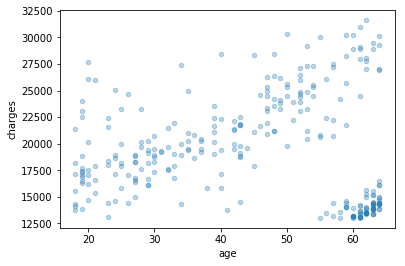

In [57]:
df_mid = df[df.charges_cat == 'mid']
df_mid.plot('age', 'charges', kind='scatter', alpha=0.3);

In [58]:
df_low[['charges','age']].corr().round(3)

,charges,age
charges,1.000,0.932
age,0.932,1.000


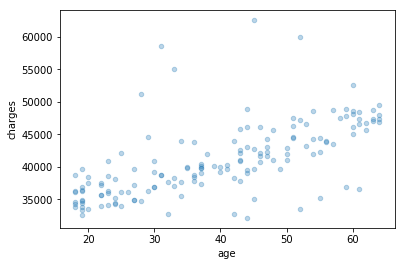

In [59]:
df_high = df[df.charges_cat == 'high']
df_high.plot('age', 'charges', kind='scatter', alpha=0.3);

In [60]:
df_high[['charges','age']].corr().round(3)

,charges,age
charges,1.000,0.638
age,0.638,1.000


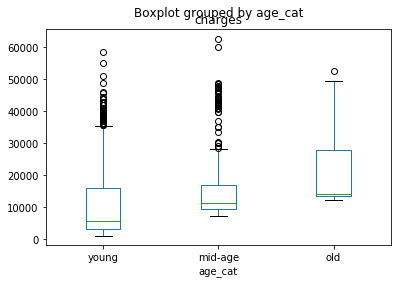

In [61]:
ax = df.boxplot(column='charges', by='age_cat', grid=False)

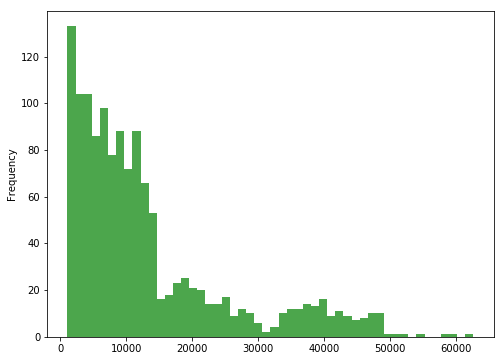

In [62]:
df.charges.plot(kind='hist', bins=50, figsize=(8,6), color='green', alpha=0.7)
plt.show()

In [63]:
cat = pd.DataFrame(df.groupby(['age_cat'])['charges'].mean())
cat

,charges
age_cat,
young,10720.744781
mid-age,15851.951266
old,21248.021885


Generally, we can draw the conclusion that the older you are, the more money you will be charged in health insurance.